In [49]:
import tensorflow as tf

# List all GPUs available to TensorFlow
gpus = tf.config.list_physical_devices('GPU')

# Check if any GPUs are available
if len(gpus) > 0:
    print("GPU is available")
    for gpu in gpus:
        print(f"GPU device: {gpu}")
else:
    print("GPU is not available")


def rl_Model(input_shape, loss):

    X_input = tf.keras.Input(input_shape)

    X = tf.keras.layers.Dense(64, activation="relu")(X_input)

    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(32, activation="relu")(X)

    X = tf.keras.layers.Dropout(0.5)(X)

    X = tf.keras.layers.Dense(16, activation="relu")(X)

    output = tf.keras.layers.Dense(2, activation="softmax")(X)

    model = tf.keras.Model(inputs=X_input, outputs=output)
    model.compile(optimizer="adam", loss=loss)

    return model

GPU is available
GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [65]:
import gym
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Question 1: Cartpole-v1
env = gym.make(
    "CartPole-v0", 
    render_mode="human"
    )

def CartPole_RL(model, discount_factor=0.95):
    
    # Save rewards for visualization later
    episode_rewards = []

    for episode in range(100):
        # print(f"CartPole-v0, episode {episode}")
        # Initiate one episode
        observation, info = env.reset()

        obs_history = []
        reward_history = []
        action_history = []

        terminated = False
        truncated = False

        # Roll out one episode
        while (not terminated) and (not truncated):
            # action = env.action_space.sample() # Policy

            # Make a prediction based on the state
            probabilities = model.predict(np.array([observation]), verbose=0)[0]

            # This line stochastically samples an action based on the probabilities
            action = np.random.choice([0, 1], p=probabilities)

            observation, reward, terminated, truncated, info = env.step(action)

            obs_history.append(observation)
            reward_history.append(reward)
            action_history.append(action)
        
        # Discount rewards
        discounted_rewards = []
        cumulative_reward = 0
        for reward in reversed(reward_history):
            cumulative_reward = reward + discount_factor * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        # Convert action_history to float32 to match the data type of the neural network output
        action_one_hot = tf.keras.utils.to_categorical(action_history, num_classes=2).astype(np.float32)
        model.train_on_batch(np.vstack(obs_history), action_one_hot, sample_weight=np.array(discounted_rewards))

        # Append episode rewards for plotting
        episode_rewards.append(np.sum(reward_history))
        
    env.close()

    # After the for loop
    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

c:\Users\nuke2\Desktop\NW Work\Fall_02 Work\MSIA-FQ2\.venv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [66]:
def policy_gradient_loss(y_true, y_pred):
    # y_true will contain the advantages
    # y_pred contains log probabilities of the actions
    print(-tf.reduce_sum(y_true * tf.math.log(y_pred)))
    return -tf.reduce_sum(y_true * tf.math.log(y_pred))

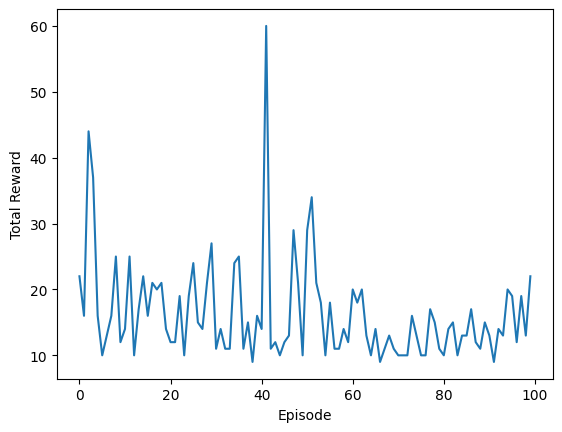

In [67]:
# Create the neural network model
model = rl_Model(input_shape=(4,), loss=policy_gradient_loss)

# Train using CartPole_RL function
CartPole_RL(model)